#Objective

Convert prediction error → ₹ impact

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

plt.style.use("seaborn-v0_8")


In [ ]:
# Load trained ensemble models
rf  = joblib.load("/content/drive/MyDrive/ATM_Forecasting_system/models/random_forest.pkl")
gb  = joblib.load("/content/drive/MyDrive/ATM_Forecasting_system/models/gradient_boosting.pkl")
xgb = joblib.load("/content/drive/MyDrive/ATM_Forecasting_system/models/xgboost.pkl")

# Load dataset with metadata
df = pd.read_csv(
    "/content/drive/MyDrive/ATM_Forecasting_system/district_month_MODEL_READY_LAGS.csv"
)

df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-" +
    df["month_num"].astype(str) + "-01"
)

test_df = df[df["year"] >= 2024].reset_index(drop=True)


In [ ]:
TARGET = "district_atm_withdrawal_volume_mn"

FEATURES = [
    c for c in test_df.columns
    if c not in [TARGET, "state_name", "district_name", "date"]
]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]


In [ ]:
pred = (
    0.4 * rf.predict(X_test) +
    0.3 * gb.predict(X_test) +
    0.3 * xgb.predict(X_test)
)

test_df["forecast_demand"] = pred
test_df["actual_demand"] = y_test.values


In [ ]:
COST_STOCKOUT = 5.0   # penalty per unit unmet demand
COST_HOLDING  = 1.0   # cost per unit excess cash


In [ ]:
k_values = np.arange(0.8, 1.31, 0.05)
results = []

for k in k_values:
    refill = k * test_df["forecast_demand"]

    shortage = np.maximum(
        test_df["actual_demand"] - refill, 0
    )
    excess = np.maximum(
        refill - test_df["actual_demand"], 0
    )

    total_cost = (
        COST_STOCKOUT * shortage.sum() +
        COST_HOLDING * excess.sum()
    )

    results.append({
        "k_multiplier": k,
        "total_cost": total_cost
    })

cost_df = pd.DataFrame(results)


In [ ]:
optimal_row = cost_df.loc[cost_df["total_cost"].idxmin()]
optimal_row


,5
k_multiplier,1.050000
total_cost,249.445757


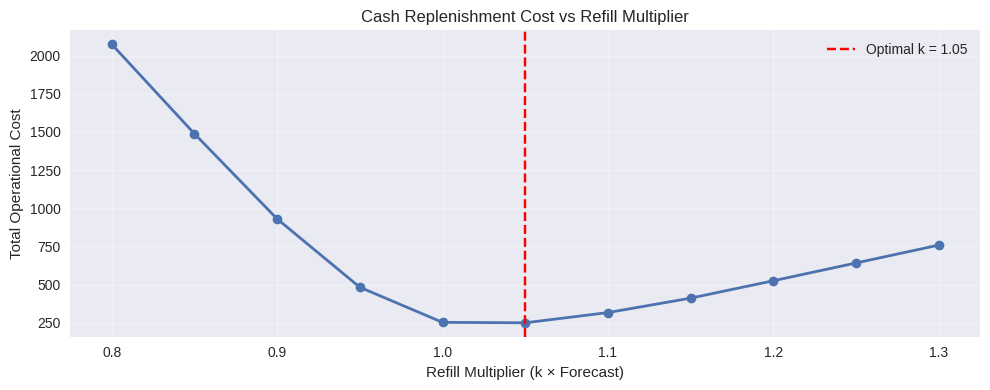

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(
    cost_df["k_multiplier"],
    cost_df["total_cost"],
    marker="o",
    linewidth=2
)

plt.axvline(
    optimal_row["k_multiplier"],
    color="red",
    linestyle="--",
    label=f"Optimal k = {optimal_row['k_multiplier']:.2f}"
)

plt.title("Cash Replenishment Cost vs Refill Multiplier")
plt.xlabel("Refill Multiplier (k × Forecast)")
plt.ylabel("Total Operational Cost")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
